# Personal Information
Name: Sebastiaan Slotboom

StudentID: 14023423

Email: sebastiaan.slotboom@student.uva.nl

Submitted on: **22-.3-2024**

# Data Context


My thesis is about bird behaviour. In particular the crab-plover is as the main subject. For this bird there are multiple behaviours which are being monitored, but manual monitoring is recource intensive. So the aim is to automate behaviour monitoring for the crabplover. The data is gathered via a sensor (imu) which the crabplover is wearing around their neck. The crabplover's accelerations in the three dimensional space is then measured. Some of the data of the crabplover is labelled and allows for superivised learning. The other data is not labelled and will be used as pre-training. The goal is to find the influence of MAE pretraining. The unlabeled data is from a database named UvA-Bits. Here numerous datasources are combined and with the right id's you can acces (in this case) the most suitable bird data. 


What data will be chosen for pretraining also depends on what labelled data is available. To see if there are similarities in terms of measurement lengths. The data gathered from the database will consist of accelerations and gps speed. The labelled data as of right now consists of accelerations. These accelerations are labelled. The category labels placed upon this data influence how the unlabeled pre-training data will be paritioned. 

# Data Description

In [2]:
# Imports
import os
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()


### Data Loading

UNLABELLED DATA

The measurements are 20Hz. Like the other measurments in this filed. This entails that each row is 1/20th of a second which will help us in determining the grouplength. The grouplength that will be used for pre-training. There can be multiple actions within one group length (g_len) so these actions must then taken into account when pre-training. 

In [4]:
#each time the date_time column changes value we know that the measurement is over. This means that when this occurs we can 
#save the length of that measurment thus far to create an overview of the lengths of the measurments in seconds


index = 1
lengte_meting = 1
metingen_lijst = []
aantal_Hz_totaal = 0

for csv_file in os.listdir('crab plover data'): #folder with all crabplover unlabeled data intheir
    if csv_file.endswith('.csv'):
        file_path = os.path.join('crab plover data', csv_file)
        dataframe_crab_plover = pd.read_csv(file_path, sep=',')
        dataframe_crab_plover['date_time'] =  pd.to_datetime(dataframe_crab_plover['date_time'])
        size = dataframe_crab_plover.size
        print(dataframe_crab_plover.size)
        aantal_Hz_totaal += size
        while index < len(dataframe_crab_plover['date_time']):
            if dataframe_crab_plover.loc[index,'date_time'] == dataframe_crab_plover.loc[index-1,'date_time']:
                lengte_meting += 1
            if dataframe_crab_plover.loc[index,'date_time'] != dataframe_crab_plover.loc[index-1,'date_time']: 
                metingen_lijst.append(lengte_meting/20) #20Hz per second, transform to seconds
                lengte_meting = 1
            index += 1
        index = 1
        print('The amount of measured seconds for this file is: ', len(metingen_lijst))

print('totaal Hz = ', aantal_Hz_totaal)



1267968
The amount of measured seconds for this file is:  1441
7137975
The amount of measured seconds for this file is:  4376
7593075
The amount of measured seconds for this file is:  7584
1628154
The amount of measured seconds for this file is:  9195
2158380
The amount of measured seconds for this file is:  11559
totaal Hz =  19785552


LABELLED DATA

In [5]:
crabplovers = pd.read_csv('annotated_acceleration_Roealnd_Bom.csv', sep=',' ) #174474 rows × 10 columns
crabplovers.head(5)

,tag,date.time,index,x,y,z,b.int,behaviour,obs.id,ind.id
0,2008,2014-11-26 00:04,0,-0.405769,0.143003,0.889336,1,stand,2008.141696,2008.1416956654.0
1,2008,2014-11-26 00:04,1,-0.386538,0.164454,0.890342,1,stand,2008.141696,2008.1416956654.1
2,2008,2014-11-26 00:04,2,-0.406731,0.147089,0.899396,1,stand,2008.141696,2008.1416956654.2
3,2008,2014-11-26 00:04,3,-0.415385,0.130746,0.897384,1,stand,2008.141696,2008.1416956654.3
4,2008,2014-11-26 00:04,4,-0.405769,0.132789,0.903421,1,stand,2008.141696,2008.1416956654.4


This shows that using a grouping length of 10 seconds (10*20 hz) of 200 would be perfect. All of the measurements below 200hz would be dropped for a uniform pretrainig sample. In analysis we see if it complies for the labelled data  

### Analysis 1: 
Now we will look into the labelled data and see what it consists of. And if it is of similar shape. 
Also I need to make a distinction clear. You have measurement times and behaviour measurement times. When the data is collected from the imu's of the birds it is not constant. It emits short measurements lasting usually no more than 10 seconds. If the date.time is the same for 10 seconds (*20 Hz) there is a measurement time of 10 seconds. If the crab-plover stands still for the first six seconds and for the remaining four seconds starts to peck, the behaviour measurment time is 6 seconds for standing in this instance, and four for pecking. 

In [6]:
crabplovers = pd.read_csv('annotated_acceleration_Roealnd_Bom.csv', sep=',' ) #174474 rows × 10 columns
crabplovers.head(5)


,tag,date.time,index,x,y,z,b.int,behaviour,obs.id,ind.id
0,2008,2014-11-26 00:04,0,-0.405769,0.143003,0.889336,1,stand,2008.141696,2008.1416956654.0
1,2008,2014-11-26 00:04,1,-0.386538,0.164454,0.890342,1,stand,2008.141696,2008.1416956654.1
2,2008,2014-11-26 00:04,2,-0.406731,0.147089,0.899396,1,stand,2008.141696,2008.1416956654.2
3,2008,2014-11-26 00:04,3,-0.415385,0.130746,0.897384,1,stand,2008.141696,2008.1416956654.3
4,2008,2014-11-26 00:04,4,-0.405769,0.132789,0.903421,1,stand,2008.141696,2008.1416956654.4


In [7]:
crabplovers.describe()
#the index, tag, behavioural integer (b.int) and the obs.id are not of any use for the analysis. 
#They are usefull for partitioning but these columns are of no more importance
#x is the acceleration 

,tag,index,x,y,z,b.int,obs.id
count,174474.000000,174474.000000,174474.000000,174380.000000,174271.000000,174474.000000,174474.000000
mean,701.983109,92.522135,-1.603541,-231.656504,1055.218142,8.358128,702.117759
std,296.934261,57.513334,556.143478,414.171266,470.629108,17.340779,296.935939
min,446.000000,0.000000,-4057.000000,-4083.000000,-4080.000000,1.000000,446.132368
25%,672.000000,42.000000,-358.000000,-499.000000,995.000000,1.000000,672.132271
50%,675.000000,89.000000,-0.698077,-113.000000,1156.000000,4.000000,675.135487
75%,682.000000,141.000000,290.000000,0.376290,1317.000000,8.000000,682.135365
max,2118.000000,199.000000,4058.000000,4070.000000,4047.000000,99.000000,2118.141717


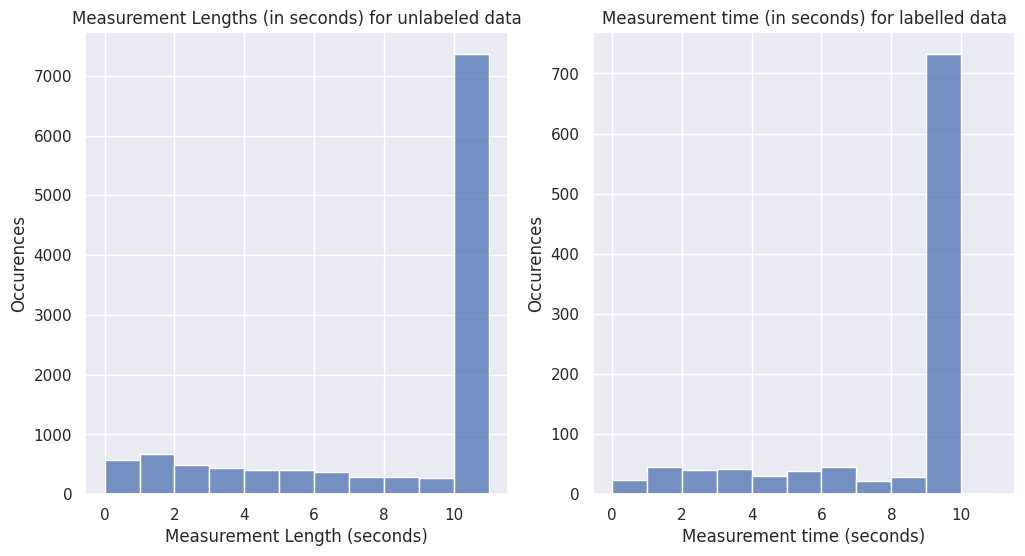

In [8]:
#distribution for labelled crabplover data
index_lengths_list = []
rownumber=2
while rownumber < len(crabplovers):
    if crabplovers.loc[rownumber,'index'] == 0:
        index_lengths_list.append(int(crabplovers.loc[rownumber-1,'index']/20))
    rownumber+=1
index_lengths_list

mean = np.mean(index_lengths_list)
std = np.std(index_lengths_list)
index_lengths_list = [x for x in index_lengths_list if (mean-3*std)<= x <= (mean+3*std)]

#distribution for unlabbeled craplover data as gathered in previous section
mean = np.mean(metingen_lijst)
std = np.std(metingen_lijst)
filtered_metingenlijst = [x for x in metingen_lijst if (mean-3*std) <= x <= (mean+3*std)] #remove outliers since these measurments are not representable


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.histplot(filtered_metingenlijst, bins=range(0, 12), ax=axs[0])
axs[0].set_title('Measurement Lengths (in seconds) for unlabeled data')
axs[0].set_xlabel('Measurement Length (seconds)')
axs[0].set_ylabel('Occurences')

sns.histplot(data=index_lengths_list, bins=range(0, 12), ax=axs[1])
axs[1].set_title('Measurement time (in seconds) for labelled data')
axs[1].set_xlabel('Measurement time (seconds)')
axs[1].set_ylabel('Occurences')

plt.show()

This already looks very similar on a big-scale. Now let's see if the distribution of actions is equally distributed over measurment lengths 

### Behavioural analysis: 
first we'll have a look at what the data is distributed like over the entire labelled dataset. For the unlabelled data set we do not know what behaviours are done. 

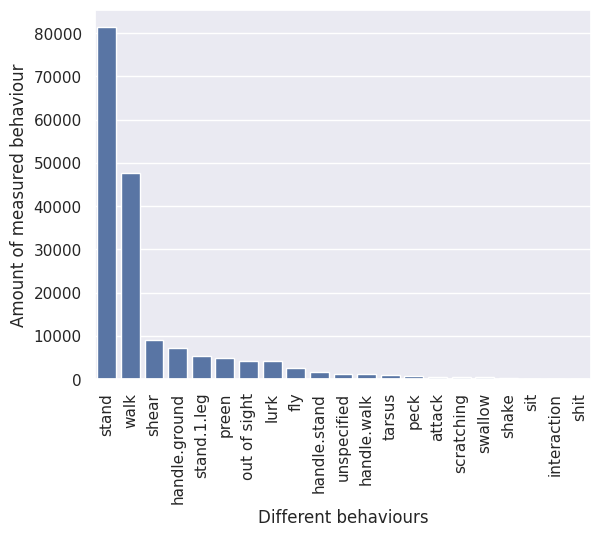

In [9]:
# This is were behaviour is counted. Take not that here we look at the amount of Hz i which a behariour occurs.
# So imagine a bird standing once for 30 hz than the bars will be 30 points higher. 
# So here is no frequency measurment but a frequency * duration visualisation

sorted_behaviours = crabplovers['behaviour'].value_counts().sort_values(ascending=False).index

sns.set()
sns.countplot(data=crabplovers, x='behaviour', order=sorted_behaviours, color=sns.color_palette('deep')[0])
plt.xticks(rotation=90)
plt.xlabel('Different behaviours')
plt.ylabel('Amount of measured behaviour')
plt.show()

In [10]:
print('the amount of different birds =',len(crabplovers['tag'].unique()))
print('the amount of measurements done by the IMU =', len(crabplovers))

the amount of different birds = 11
the amount of measurements done by the IMU = 174474


See if there is a correlation between behaviour and measuring time.

For instance it might be that a sensor stops measuring if there is little movement. If it turns out to be the case, this is sensitive information for the ublabeled pre-training dataset. That entails that we cannot use the standard 10 second measurement then.

In [11]:
columns = ['tag', 'x', 'y', 'z', 'behaviour', 'measurmenttime_behaviour', 'measurmenttime_measurement']

behaviour_summary = pd.DataFrame(columns=columns) #hieraan de gedragsrijen toevoegen. 


index_start = 0
index_end = 1

#this function loops through the data and first snips it into seperate observations(measurement times)
#then it seperates them into seperate behaviours (behavioural measurment times)
#then it is added to the behaviour_summary which shows the measurments surrounding behaviours
while index_end < len(crabplovers)-2 :
    if crabplovers.loc[index_end, 'index'] < crabplovers.loc[index_end+1, 'index']:
        index_end += 1 
    if crabplovers.loc[index_end, 'index'] >= crabplovers.loc[index_end+1, 'index']:
        one_measurment_time = crabplovers.loc[index_start:index_end,:] #part of table containing one measurment
        one_measurment_time.sort_values(by='b.int')
        for item in one_measurment_time['b.int'].unique():
            one_behaviour = one_measurment_time[one_measurment_time['b.int']==item]
            # ['tag', 'x', 'y', 'z', 'behaviour', 'measurmenttime_behaviour', 'measurmenttime_measurement']
            behaviour_summary.loc[len(behaviour_summary)] = [
                one_behaviour.iloc[0,0], #tag
                one_behaviour['x'].mean(),
                one_behaviour['y'].mean(),
                one_behaviour['z'].mean(),
                one_behaviour.iloc[0,7], #behaviour
                len(one_behaviour),
                index_end - index_start]
        index_start = index_end
        index_end += 1


In [12]:
behaviour_summary.head(5) #2605 rows × 7 column

,tag,x,y,z,behaviour,measurmenttime_behaviour,measurmenttime_measurement
0,2008,-0.392030,0.148364,0.905514,stand,149,199
1,2008,-0.269721,0.197060,0.928769,walk,51,199
2,2008,-0.234171,0.220242,0.944493,stand,201,200
3,2008,-0.027404,0.148091,0.976558,stand,106,200
4,2008,0.028715,0.167013,0.965625,walk,95,200


Text(0, 0.5, 'behavrioural measurement time (in Hz)')

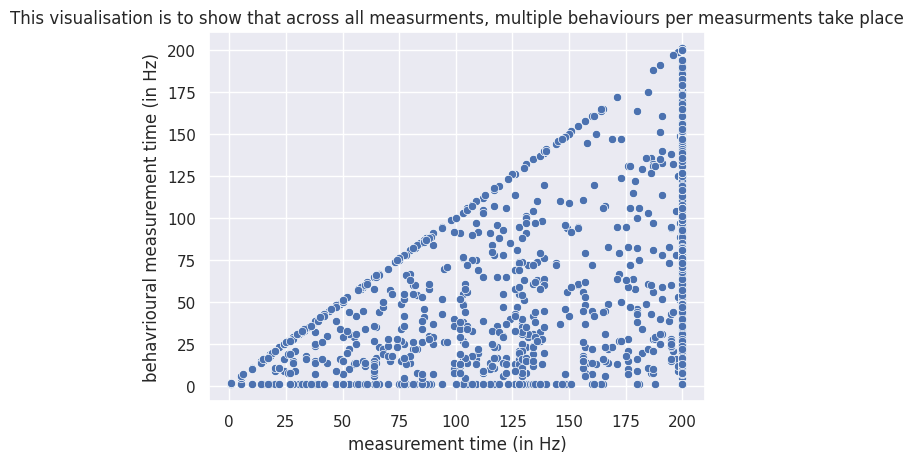

In [13]:
sns.scatterplot(data= behaviour_summary, x='measurmenttime_measurement', y='measurmenttime_behaviour') 
plt.title("This visualisation is to show that across all measurments, multiple behaviours per measurments take place")
plt.xlabel("measurement time (in Hz)")
plt.ylabel("behavrioural measurement time (in Hz)")

/tmp/ipykernel_4452/2223670665.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)


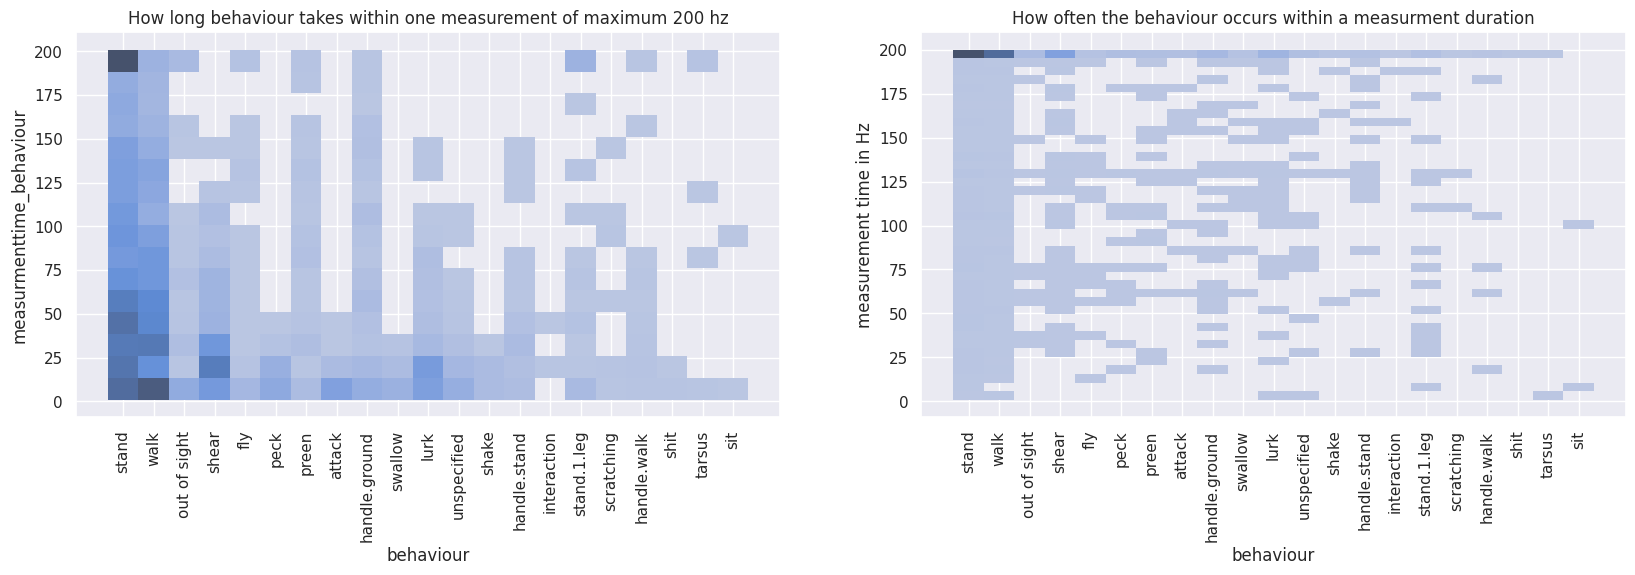

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
sns.histplot(data=behaviour_summary, x='behaviour', y='measurmenttime_behaviour', ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
axes[0].set_title("How long behaviour takes within one measurement of maximum 200 hz")
sns.histplot(data=behaviour_summary, x='behaviour', y='measurmenttime_measurement', ax=axes[1])
plt.xticks(rotation=90)
plt.title("How often the behaviour occurs within a measurment duration")
plt.ylabel('measurement time in Hz')
plt.show()


Now we want to check if there is a difference between the way behaviours are measured in a 200 hz measurement vs. a lower amount. If there is not a significant difference it means that there is no correlation between measurment time and behaviour monitored. Which allows for us to use only the 200 Hz (aka 10 seconds) data as input

/tmp/ipykernel_4452/2207457138.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
/tmp/ipykernel_4452/2207457138.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)


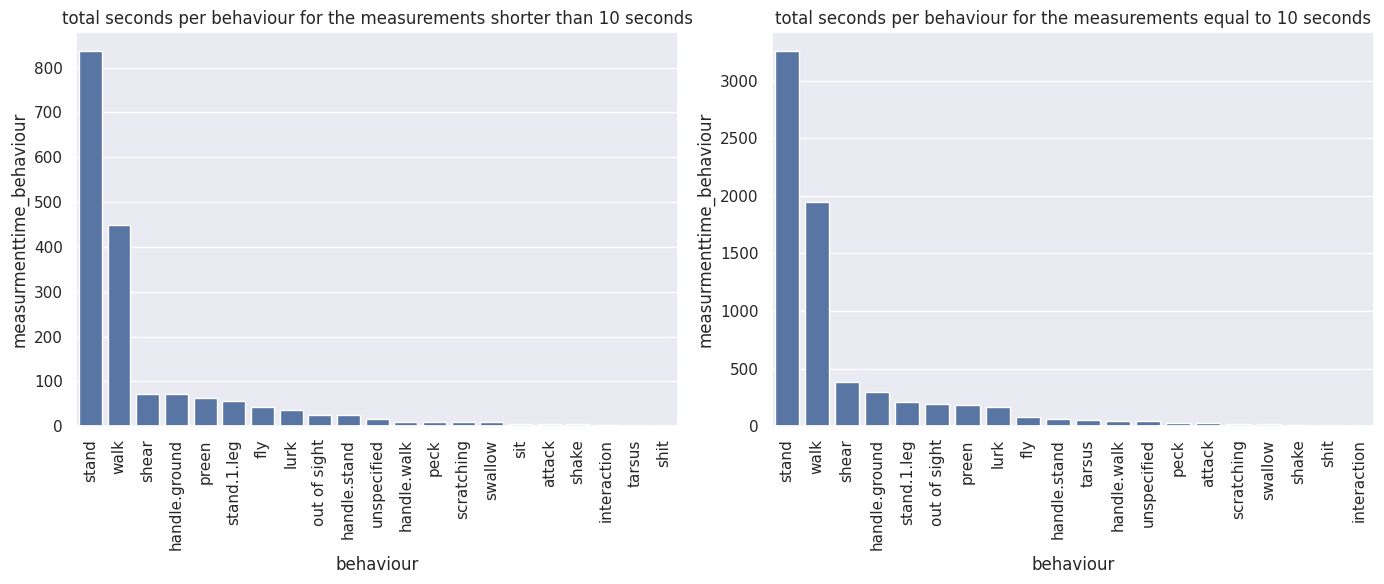

In [15]:

#behaviour_summary[behaviour_summary['behaviour']!= 'out of sight']
kort = behaviour_summary[behaviour_summary['measurmenttime_measurement'] < 200] 
#kort = kort[kort['behaviour'] != 'sit']  
lang = behaviour_summary[behaviour_summary['measurmenttime_measurement'] == 200]

kort_sum = (kort.groupby('behaviour')['measurmenttime_behaviour'].sum()/20).reset_index() #/20 for hz to seconds
lang_sum = (lang.groupby('behaviour')['measurmenttime_behaviour'].sum()/20).reset_index()

kort_sum.sort_values(by='measurmenttime_behaviour', inplace=True, ascending=False)
lang_sum.sort_values(by='measurmenttime_behaviour', inplace=True, ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(data=kort_sum, x='behaviour', y='measurmenttime_behaviour', ax=axes[0])
axes[0].set_title('total seconds per behaviour for the measurements shorter than 10 seconds')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)

sns.barplot(data=lang_sum, x='behaviour', y='measurmenttime_behaviour', ax=axes[1])
axes[1].set_title('total seconds per behaviour for the measurements equal to 10 seconds')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()



From these barplots it becomes clear that there is no real difference between the two sets. Only the shorter measurments have encountered the 'sit' activity, which is removed from further usage. Also the 'out of sight' datapoints will be removed since that is not an action but an annotation failure. 

### Analysis :
Given the spread for the unlabelled data; roughly three quarters is contained in the 10 second measurment ratio. THe unlabeled data to which the rest of the analysis will be done is based soley on the 10 second data. This data will encapsulate the same behaviour are the shorter measurement would do, based on the earlier composition of the data. It will be extracted here. 

In [16]:
#IGNORE
gedraglijst = lang['behaviour'].unique() #- "out of sight" 

#fig, axes = plt.subplots(nrows=len(gedraglijst), figsize=(15, 100))

#for item in gedraglijst:
x_values =lang[lang['behaviour'] == gedraglijst[0]].x
y_values =lang[lang['behaviour'] == gedraglijst[0]].y
z_values = lang[lang['behaviour'] == gedraglijst[0]].z
#print("x", x_values)
#print("y", y_values)
#print("z", z_values)

#sns.scatterplot(x= x_values, y=y_values)
mean = x_values.mean()
std = x_values.std()
print("mean", mean)
print("std", std)

plt.tight_layout()
plt.show()

mean -175.30867723069807
std <bound method Series.std of 2      -0.234171
3      -0.027404
8      -0.505881
13     -0.367951
17     -0.695285
          ...   
2589   -0.349314
2593   -0.304231
2594   -0.293688
2596   -0.236126
2599   -0.133136
Name: x, Length: 616, dtype: float64>


<Figure size 640x480 with 0 Axes>

Loading unlabelled data

In [62]:
dfs = []
for subdir, dirs, files in os.walk('crab plover data new'):
    for file in files:
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(subdir, file), sep=',', header=0, index_col=0)
            dfs.append(df)

unlabeled_total = pd.concat(dfs, ignore_index=True)
unlabeled_total.rename(columns= {'0': 'date', '1': 'x', '2': 'y', '3': 'z', '4': 'speed'},inplace=True)
unlabeled_total

,date,x,y,z,speed
0,1321996256,0.025816,0.025777,0.982668,0.071759
1,1321996256,0.025816,0.025777,0.982668,0.071759
2,1321996256,0.022020,0.026535,1.006782,0.071759
3,1321996256,0.018983,0.025777,1.006782,0.071759
4,1321996256,0.018983,0.029568,1.006782,0.071759
...,...,...,...,...,...
1196395,1322987074,-0.252672,0.384787,0.896234,0.011372
1196396,1322987074,-0.256489,0.396719,0.896234,0.011372
1196397,1322987074,-0.245802,0.389262,0.896234,0.011372
1196398,1322987074,-0.251908,0.395227,0.896234,0.011372


showcasing spread of distribution in unlabeled data

Showcasing the difference in spread when removing the data outside of 3 standard deviations. The big difference between the upper row (including every datapoint) and the lower row (excluding every datapoint) is quite marginal. But since we cannot just ignore the outliers in our time series data some data preparation must take place. (when removing an x-outlier you would possibly remove a perfectly fine y and z value since you cannot just add NaNs, thus removing a lot of data and making the data less continuous). 

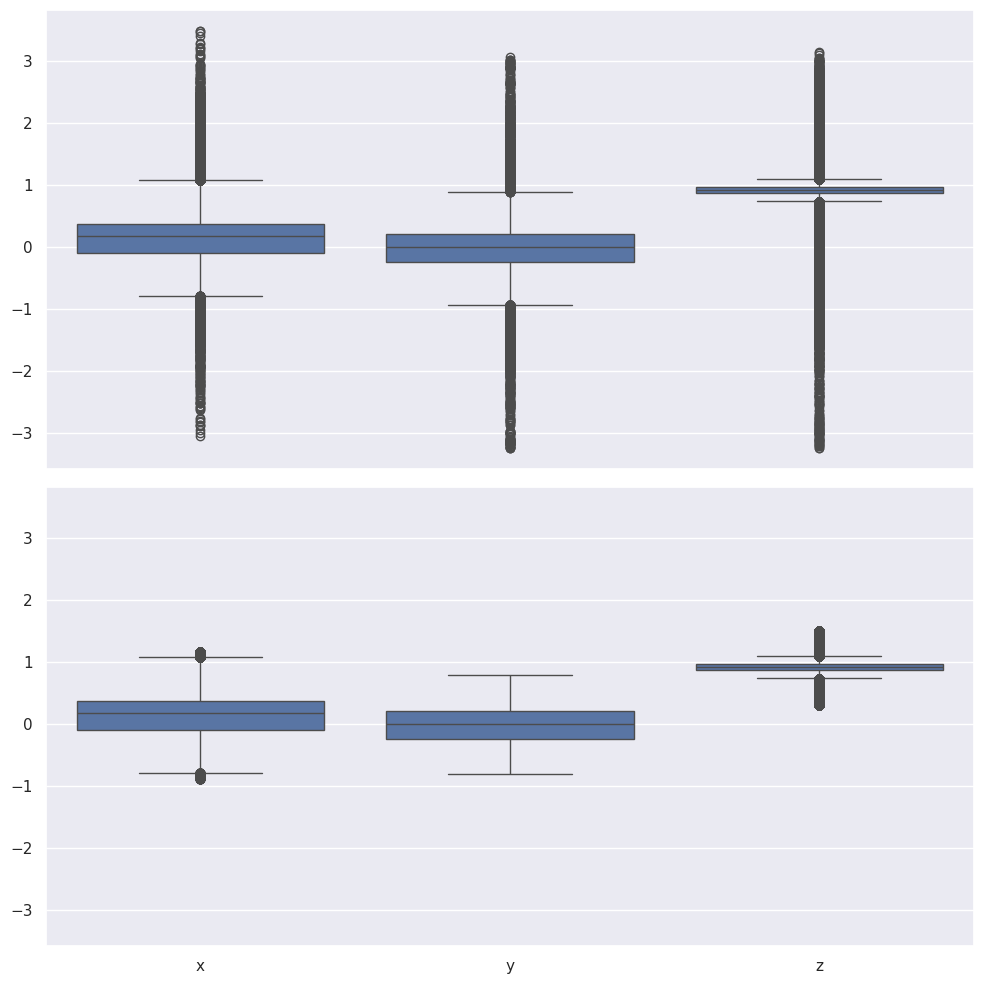

In [63]:
#testje = pd.read_csv('640_imu_en_snelheid.csv', header=None)
#testje.columns = ['','date','x', 'y', 'z', 'speed']
fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True, sharey=True)

# Unnormalized versions
x_values = pd.DataFrame(unlabeled_total['x'])
sns.boxplot(data=x_values, ax=axs[0])
y_values = pd.DataFrame(unlabeled_total['y'])
sns.boxplot(data=y_values, ax=axs[0])
z_values = pd.DataFrame(unlabeled_total['z'])
sns.boxplot(data=z_values, ax=axs[0])

# Normalized versions
x_values = unlabeled_total['x']
mean = x_values.mean()
std = x_values.std()
filtered_values = [x for x in x_values if mean - 3 * std < x < mean + 3 * std]
x_values_filter_test = pd.DataFrame(filtered_values, columns=['x'])
sns.boxplot(data=x_values_filter_test, ax=axs[1])

y_values = unlabeled_total['y']
mean = y_values.mean()
std = y_values.std()
filtered_values = [y for y in y_values if mean - 3 * std < y < mean + 3 * std]
y_values_filter_test = pd.DataFrame(filtered_values, columns=['y'])
sns.boxplot(data=y_values_filter_test, ax=axs[1])

z_values = unlabeled_total['z']
mean = z_values.mean()
std = z_values.std()
filtered_values = [z for z in z_values if mean - 3 * std < z < mean + 3 * std]
z_values_filter_test = pd.DataFrame(filtered_values, columns=['z'])
sns.boxplot(data=z_values_filter_test, ax=axs[1])

fig.tight_layout()
plt.show()


All accelerations shown from unlabeled data, thus disregarding behaviour


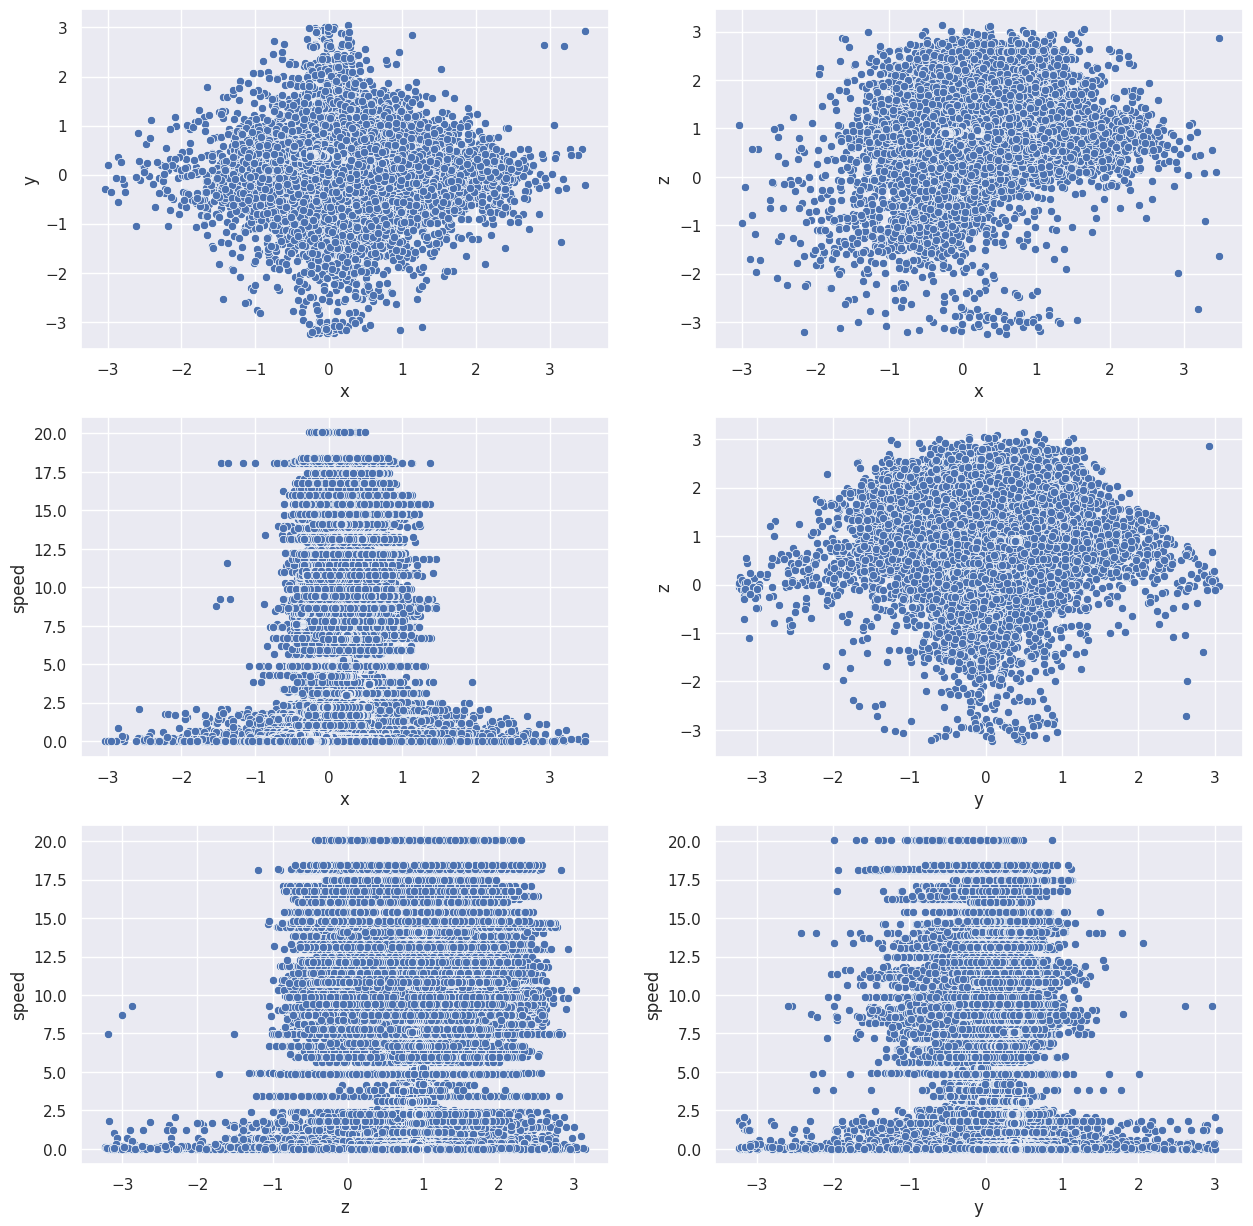

In [64]:
#testje = pd.read_csv('640_imu_en_snelheid.csv', header=None)
#testje.columns = ['','date','x', 'y', 'z', 'speed']
print("All accelerations shown from unlabeled data, thus disregarding behaviour")
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
sns.scatterplot(data=unlabeled_total, x='x', y='y', ax=axs[0, 0])
sns.scatterplot(data=unlabeled_total, x='x', y='z', ax=axs[0, 1])
sns.scatterplot(data=unlabeled_total, x='x', y='speed', ax=axs[1, 0])
sns.scatterplot(data=unlabeled_total, x='y', y='z', ax=axs[1, 1])
sns.scatterplot(data=unlabeled_total, x='y', y='speed', ax=axs[2, 1])
sns.scatterplot(data=unlabeled_total, x='z', y='speed', ax=axs[2, 0])
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScale

def min_max_all_matrices(self, all_matrices):
        #using a minmax scaler
        scaler = MinMaxScaler()
        scaled_arrays = []
        for array in all_matrices:
            array_reshaped = array.reshape(-1, 1)
            scaled_array_reshaped = scaler.fit_transform(array_reshaped)
            scaled_array = scaled_array_reshaped.reshape(array.shape)
            scaled_arrays.append(scaled_array)
        return scaled_arrays



The spread for x, y and z reveal that the labelled data has odd values and probably needs to be restructured. Some values are altered to be within -3 to +3 whilst others are not

/tmp/ipykernel_456621/269492270.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
/tmp/ipykernel_456621/269492270.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)
/tmp/ipykernel_456621/269492270.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=90)


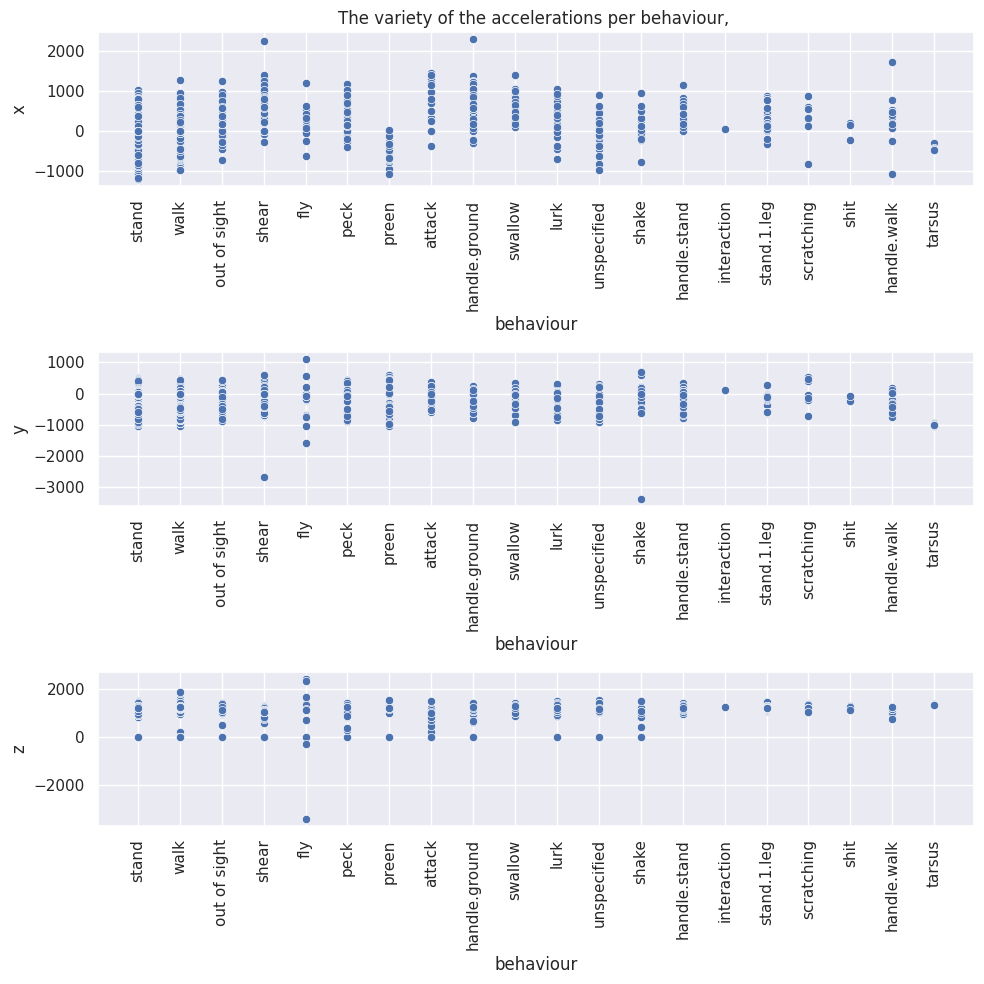

In [ ]:
fig, axs = plt.subplots(nrows=3, figsize=(10, 10))

sns.scatterplot(data=lang, x='behaviour', y='x', ax=axs[0])
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
axs[0].set_title("The variety of the accelerations per behaviour, ")
sns.scatterplot(data=lang, x='behaviour', y='y', ax=axs[1])
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)
sns.scatterplot(data=lang, x='behaviour', y='z', ax=axs[2])
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

/tmp/ipykernel_456621/3942234966.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_456621/3942234966.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_456621/3942234966.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)


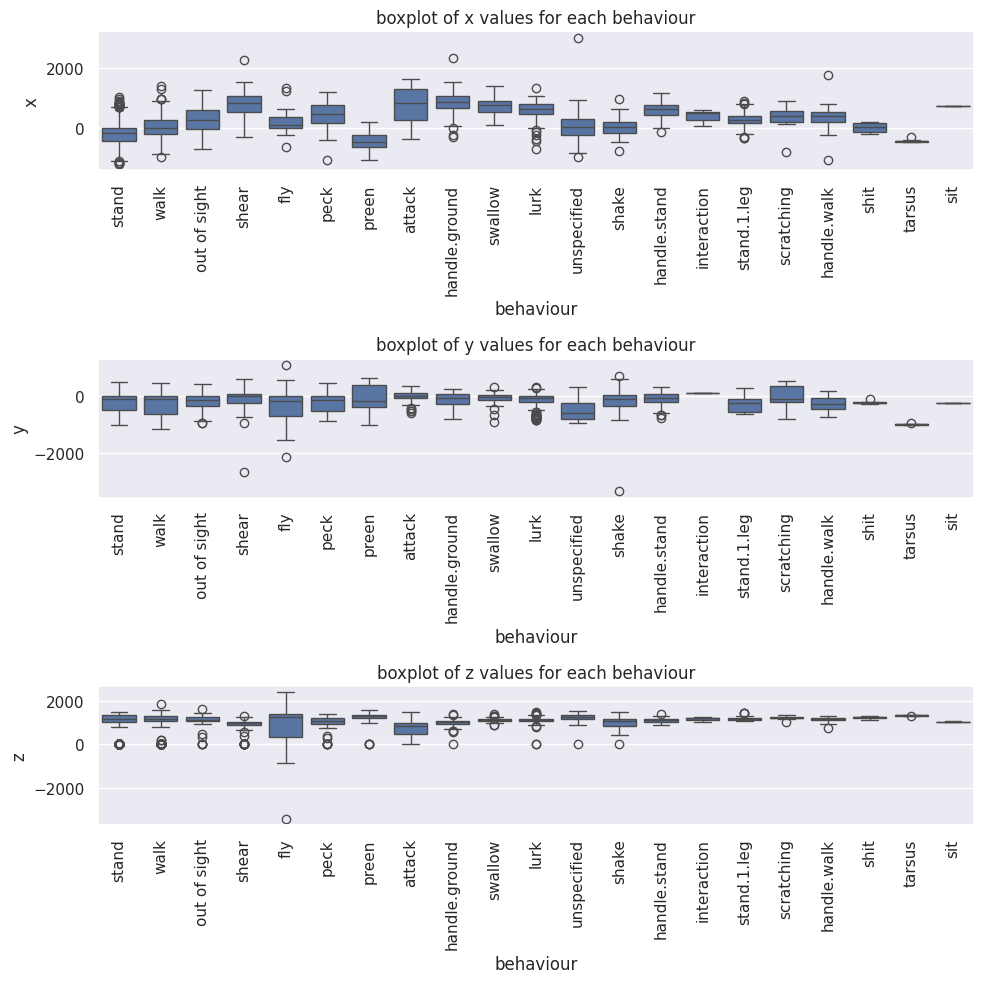

In [ ]:
fig, axs = plt.subplots(nrows=3, figsize=(10, 10))

for i, var in enumerate(['x', 'y', 'z']):
    sns.boxplot(data=behaviour_summary, x='behaviour', y=var, ax=axs[i])
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
    axs[i].set_title(f"boxplot of {var} values for each behaviour")

plt.tight_layout()
plt.show()

### Seagulls
As is noticable above; the labelled data from the crab-plovers leaves room for improvement. It is hard to showcase correlations between accelerations and behaviour if the accelerations are sometimes normalised and sometimes not. This will have to be fixed so there is contact with the source who gave me this data. Looking forward to see what it will bring.

Now there is also another dataset available. This is the dataset for seagulls. This is correctly annotated and also includes speed. This dataset only contains measurments that are 1 second in length (20Hz) and are thus usefull for classification. For object recognition a longer period is usefull.  

In [74]:
seagull = pd.read_csv('Copy of combined_s_w_m_j.csv', sep=',', header=None)
seagull.rename(columns={0:'tag', 1 : 'Date_time', 2: 'id_i_think', 3: 'integer behaviour', 4: 'x', 5:'y', 6: 'z', 7: 'speed'}, inplace=True)
seagull.head(5)

,tag,Date_time,id_i_think,integer behaviour,x,y,z,speed
0,805,2014-06-05 11:16:27,20,2,0.245977,-0.170099,0.749424,10.28987
1,805,2014-06-05 11:16:27,20,2,0.276628,-0.188406,0.749424,10.28987
2,805,2014-06-05 11:16:27,20,2,0.287356,-0.209764,0.798616,10.28987
3,805,2014-06-05 11:16:27,20,2,0.284291,-0.198322,0.749424,10.28987
4,805,2014-06-05 11:16:27,20,2,0.304215,-0.158658,0.922367,10.28987


Flight
<p>	0=Flap=634
<p>	1=ExFlap=38
<p>	2=Soar=501
<p> 3=Sit/Stand on Boat=176
<p>	4=Float=558
<p> 5=SitStand/Stationary=894
<p> 6=Terrestial locomotion 318
<p> 7=other=25
<p>	8=Manouvre/Mixed=151
<p> 9=pecking
<p>Float

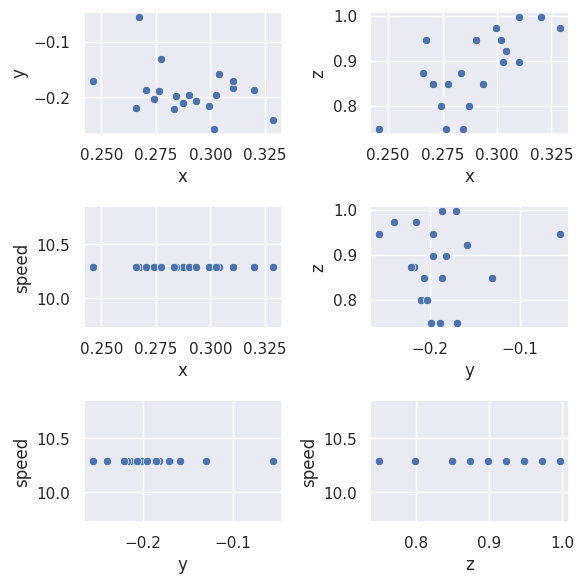

In [76]:
seagull[0:20] #soar

fig, axes = plt.subplots(3, 2, figsize=(6, 6))

sns.scatterplot(data=seagull[0:20], x='x', y='y', ax=axes[0, 0])
sns.scatterplot(data=seagull[0:20], x='x', y='z', ax=axes[0, 1])
sns.scatterplot(data=seagull[0:20], x='x', y='speed', ax=axes[1, 0])
sns.scatterplot(data=seagull[0:20], x='y', y='z', ax=axes[1, 1])
sns.scatterplot(data=seagull[0:20], x='y', y='speed', ax=axes[2, 0])
sns.scatterplot(data=seagull[0:20], x='z', y='speed', ax=axes[2, 1])

plt.tight_layout()
plt.show()

#This shows that x and z have a correlation for this specific soaring instance. 

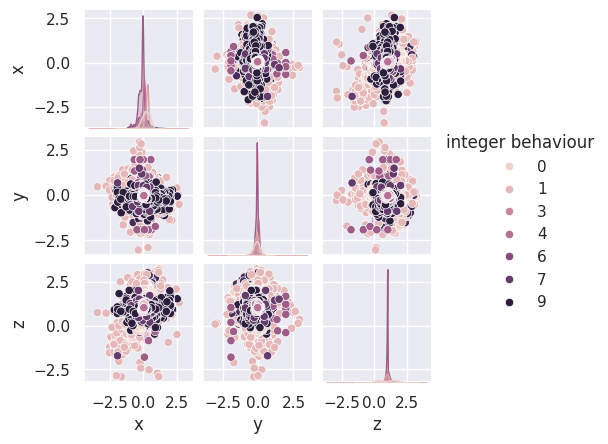

In [84]:
sns.pairplot(seagull[['x','y','z','integer behaviour']], hue='integer behaviour', height=1.5)

<Axes: >

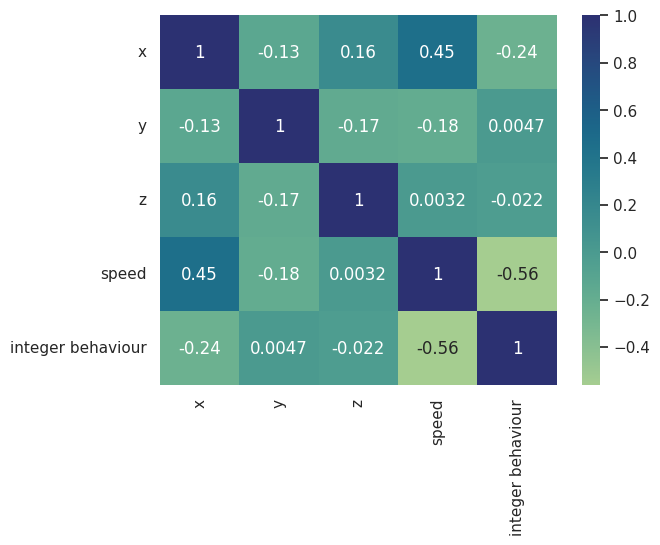

In [89]:
sns.heatmap(seagull[['x','y','z','speed','integer behaviour']].corr(), annot=True,cmap='crest')

### Visualisation 

In order to better understand what all the measurments are here is a visualisation of what the data entails

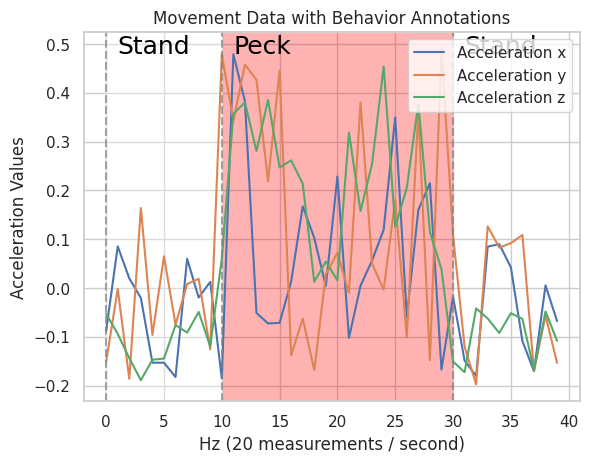

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# This is mock data generated to visualise what a measurement looks like for the algorithm

np.random.seed(42)  # for reproducibility
array1 = np.hstack((np.random.uniform(-0.2, 0.1, 10), np.random.uniform(-0.2, 0.5, 20), np.random.uniform(-0.2, 0.1, 10)))
array2 = np.hstack((np.random.uniform(-0.2, 0.2, 10), np.random.uniform(-0.2, 0.5, 20), np.random.uniform(-0.2, 0.2, 10)))
array3 = np.hstack((np.random.uniform(-0.2, -0.03, 10), np.random.uniform(0.0, 0.5, 20), np.random.uniform(-0.2, -0.03, 10)))
time_points = np.arange(40)

# Set Seaborn style
sns.set(style="whitegrid")
plt.plot(time_points, array1, label='Acceleration x')
plt.plot(time_points, array2, label='Acceleration y')
plt.plot(time_points, array3, label='Acceleration z')

# Annotate certain blocks with behavior labels
behaviors = ['Stand', 'Peck', 'Stand']
behavior_times = [0, 10, 30]  # Example time points for behaviors

for behavior, time_point in zip(behaviors, behavior_times):
    plt.axvline(x=time_point, color='gray', linestyle='--', alpha=0.7)
    plt.text(time_point + 1, 0.48, behavior, rotation=0, fontsize=18, color='black')


for i in range(0, len(behavior_times) - 1, 2):  # Adjusted loop range
    start_time = behavior_times[i]
    end_time = behavior_times[i + 1]
    plt.axvspan(start_time, end_time, facecolor='white', alpha=0.3)

# Add shaded background for 'Peck' compartment
peck_start = behavior_times[1]
peck_end = behavior_times[2]

plt.axvspan(peck_start, peck_end, facecolor='red', alpha=0.3)
plt.xlabel('Hz (20 measurements / second)')
plt.ylabel('Acceleration Values')
plt.title('Movement Data with Behavior Annotations')
plt.legend()
plt.show()


GIthub = SebastiaanProjects 

https://github.com/SebastiaanProjects/EDA.git